

# <!-- TITLE --> [VAE1] - First VAE, using functional API 
<!-- DESC --> Construction and training of a VAE, using functional APPI, with a latent space of small dimension.


## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding **Keras functional API**, using two custom layers

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.layers    import SamplingLayer, VariationalLossLayer
from modules.callbacks import ImagesCallback, BestModelCallback

import sys
import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('VAE1')


2023-04-13 20:12:31.608974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : VAE1
Run dir              : ./run/VAE1
Datasets dir         : /Users/dagoret/MacOSX/Fidle2023/fidle-tp/datasets-fidle
Start time           : 13/04/23 20:12:38
Hostname             : MacBook-Pro-de-admin.local (Darwin)
Tensorflow log level : Warning + Error  (=1)
Update keras cache   : False
Save figs            : ./run/VAE1/figs (False)
tensorflow           : 2.12.0
tensorflow.keras     : 2.12.0
numpy                : 1.23.5
sklearn              : 1.2.2
skimage              : 0.20.0
matplotlib           : 3.7.1
pandas               : 2.0.0


In [2]:
import h5py

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !\
`fit_verbosity`: Verbosity of training progress bar: 0=silent, 1=progress bar, 2=One line  

`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,.001\] gives good results here.


In [4]:
latent_dim    = 2
loss_weights  = [1,.1]

scale         = 1
seed          = 123

batch_size    = 16
epochs        = 70
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [5]:
fidle.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs', 'fit_verbosity')

## Step 3 - Prepare data


In [6]:
hf = h5py.File('SLspectra.hdf5', 'r') 
data_in = hf['flambda'][:]
wl_in = hf['wl'][:]
target = hf['quantile'][:]
print(hf.keys())

<KeysViewHDF5 ['RT', 'RV', 'Rmag', 'dec', 'flambda', 'num', 'quantile', 'ra', 'redshift', 'wl']>


In [7]:
NWL = data_in.shape[1]
NSAMPL = data_in.shape[0]

In [8]:
spectra = data_in
wavelengths = wl_in

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]
meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]


## Step 4 - Build model
In this example, we will use the **functional API.**  
For this, we will use two custom layers :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VariationalLossLayer`, which allows us to calculate the loss function, loss - See : [VariationalLossLayer.py](./modules/layers/VariationalLossLayer.py)

#### Encoder

In [9]:
inputs    = keras.Input(shape=(NWL,))
x         = layers.Dense(256, activation="relu")(inputs)
x         = layers.Dense(64, activation="relu")(x)
x         = layers.Dense(32, activation="relu")(x)


z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          2560256     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           16448       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                            

#### Decoder

In [10]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(32, activation="relu")(inputs)
x       = layers.Dense(64, activation="relu")(x)
x       = layers.Dense(256,activation="relu") (x)
outputs = layers.Dense(NWL, activation="relu")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 32)                96        
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 256)               16640     
                                                                 
 dense_6 (Dense)             (None, 10000)             2570000   
                                                                 
Total params: 2,588,848
Trainable params: 2,588,848
Non-trainable params: 0
_________________________________________________________________


#### VAE

We will calculate the loss with a specific layer: `VariationalLossLayer` - See : [VariationalLossLayer.py](./modules/layers/VariationalLossLayer.py)

In [11]:

inputs = keras.Input(shape=(None, NWL))

z_mean, z_log_var, z = encoder(inputs)
outputs              = decoder(z)

outputs = VariationalLossLayer(loss_weights=loss_weights)([inputs, z_mean, z_log_var, outputs])

vae=keras.Model(inputs,outputs)

vae.compile(optimizer='adam', loss=None)

## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [12]:
#callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
#callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_bestmodel]

### 5.2 - Let's train !


In [13]:
chrono=fidle.Chrono()
chrono.start()

history = vae.fit(normedspectra, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,verbose=fit_verbosity)

chrono.show()

Epoch 1/70
35/35 [==============================] - 4s 57ms/step - loss: 0.7673 - r_loss: -0.5471 - kl_loss: 1.3144
Epoch 2/70
35/35 [==============================] - 2s 54ms/step - loss: 0.1517 - r_loss: -0.9846 - kl_loss: 1.1363
Epoch 3/70
35/35 [==============================] - 2s 52ms/step - loss: -0.9844 - r_loss: -1.1976 - kl_loss: 0.2131
Epoch 4/70
35/35 [==============================] - 2s 72ms/step - loss: -1.2644 - r_loss: -1.5431 - kl_loss: 0.2787
Epoch 5/70
35/35 [==============================] - 2s 58ms/step - loss: -1.3390 - r_loss: -1.6738 - kl_loss: 0.3348
Epoch 6/70
35/35 [==============================] - 2s 62ms/step - loss: -1.4534 - r_loss: -1.6536 - kl_loss: 0.2002
Epoch 7/70
35/35 [==============================] - 2s 56ms/step - loss: -1.4452 - r_loss: -1.7083 - kl_loss: 0.2630
Epoch 8/70
35/35 [==============================] - 2s 65ms/step - loss: -1.2877 - r_loss: -1.7991 - kl_loss: 0.5114
Epoch 9/70
35/35 [==============================] - 2s 59ms/step -

## Step 6 - Training review
### 6.1 - History

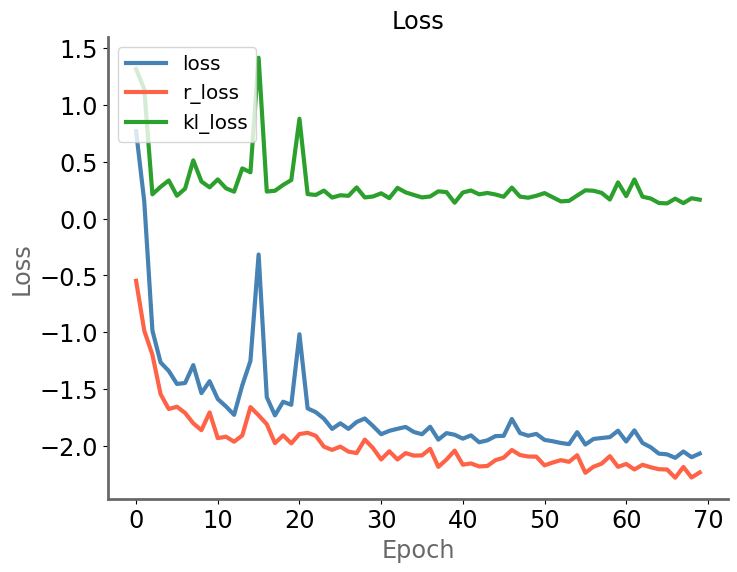

In [14]:
fidle.scrawler.history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

## Annexe - Model Save and reload 

In [15]:
filename = run_dir+'/models/my_model.h5'

# ---- Save our model :

vae.save(filename)

# ---- Reload it

vae = keras.models.load_model(filename, custom_objects={'SamplingLayer': SamplingLayer, 'VariationalLossLayer':VariationalLossLayer})

# ---- Retrieve a layer

decoder = vae.get_layer('decoder')


In [16]:
fidle.end()

**End time :** 13/04/23 20:15:04  
**Duration :** 00:02:26 315ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)